<a href="https://colab.research.google.com/github/ennbie/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Detection using brain MRI images

Dataset obtained from : [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DIRECTORY = "./drive/MyDrive/Brain tumor detection/"
DATA_PATH = DIRECTORY + "brain_tumor_dataset/"

## Importing packages

In [43]:
import os
import shutil
import random
import math
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


## Splitting Dataset into Training, Testing and Validation sets

In [4]:
SEED = 123
train = DIRECTORY + "train/"
test = DIRECTORY + "test/"
validation = DIRECTORY + "validation/"

In [ ]:
for path in [train,test,validation]:
  os.makedirs(path + "yes/")
  os.makedirs(path + "no/")

In [5]:
test_examples = train_examples = validation_examples = 0

In [6]:
for yes_no in os.listdir(DATA_PATH):
      n = len(os.listdir(DATA_PATH + yes_no))
      for (i, file_name) in enumerate(os.listdir(DATA_PATH + yes_no)):
          img = DATA_PATH + yes_no + '/' + file_name
          if i < 5:
              shutil.copy(img, test + yes_no + '/' + file_name)
              test_examples += 1
          elif i < 0.8*n:
              shutil.copy(img, train + yes_no + '/' + file_name)
              train_examples += 1
          else:
              shutil.copy(img, validation + yes_no + '/' + file_name)
              validation_examples += 1

In [7]:
print(f"Number of training examples: {train_examples}")
print(f"Number of test examples: {test_examples}")
print(f"Number of validation examples: {validation_examples}")

Number of training examples: 193
Number of test examples: 10
Number of validation examples: 50


## Image Loading and Preprocessing

In [8]:
def load_data(path):
  X=[]
  Y=[]
  for img_file in glob.iglob(path+"yes/*"):
      img = cv2.imread(img_file)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224))
      X.append(img)
      Y.append(1)

  for img_file in glob.iglob(path+"no/*"):
      img = cv2.imread(img_file)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
      X.append(img)
      Y.append(0)

  return np.array(X), np.array(Y)

X_train, Y_train = load_data(train)
X_test, Y_test = load_data(test)
X_val, Y_val = load_data(validation)

## Visualizing Brain MRI Images

1. Plot random images from dataset

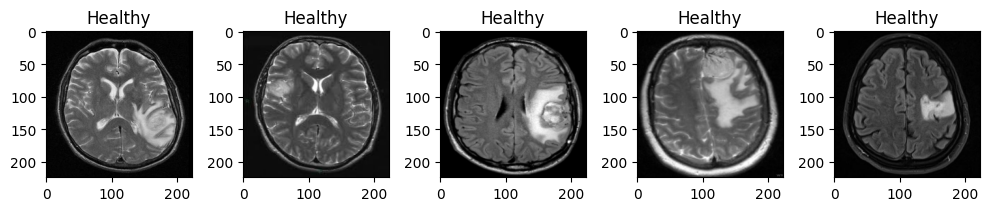

In [9]:
index = np.random.choice(X_train.shape[0], 5, replace=False)
plt.figure(figsize=(10,10))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[index[i]])
    plt.title("Healthy" if Y_train[index[i]]==1 else "Tumor")

plt.tight_layout()
plt.show()

2. Plot examples of images with tumor and without tumor

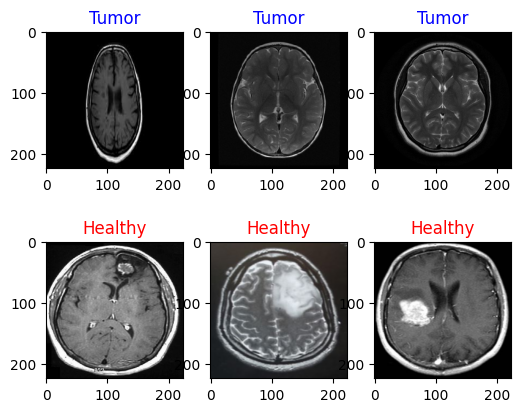

In [10]:
# Define the labels and their corresponding colors
labels = {0: 'Tumor', 1: 'Healthy'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(6, 5))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, Y_train) if y == label][:3]
    for j,img in enumerate(images):
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

## Data Augmentation

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(
    X_train,
    Y_train,
    batch_size=32,
    shuffle=True,
    seed=SEED
)

val_generator = test_datagen.flow(
    X_val,
    Y_val,
    batch_size=16,
    shuffle=True,
    seed=SEED
)

## Constructing Model using Transfer Learning on VGG16

In [24]:
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224,224) + (3,)
                   )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [26]:
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.layers[0].trainable = False

In [55]:
model.compile(
    loss = "binary_crossentropy",
    optimizer = Adam(),
    metrics=["accuracy"]
)

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [56]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
)

Epoch 1/50
7/7 [==============================] - 5s 422ms/step - loss: 0.1117 - accuracy: 0.9482 - val_loss: 0.2610 - val_accuracy: 0.9200
Epoch 2/50
7/7 [==============================] - 5s 650ms/step - loss: 0.1221 - accuracy: 0.9326 - val_loss: 0.2473 - val_accuracy: 0.9000
Epoch 3/50
7/7 [==============================] - 3s 402ms/step - loss: 0.0853 - accuracy: 0.9637 - val_loss: 0.2131 - val_accuracy: 0.9000
Epoch 4/50
7/7 [==============================] - 3s 400ms/step - loss: 0.0696 - accuracy: 0.9793 - val_loss: 0.2404 - val_accuracy: 0.9200
Epoch 5/50
7/7 [==============================] - 3s 397ms/step - loss: 0.1199 - accuracy: 0.9430 - val_loss: 0.2669 - val_accuracy: 0.9000
Epoch 6/50
7/7 [==============================] - 4s 575ms/step - loss: 0.0842 - accuracy: 0.9689 - val_loss: 0.2167 - val_accuracy: 0.9200
Epoch 7/50
7/7 [==============================] - 3s 407ms/step - loss: 0.0476 - accuracy: 0.9896 - val_loss: 0.2344 - val_accuracy: 0.9400
Epoch 8/50
7/7 [====

## Plot model performance

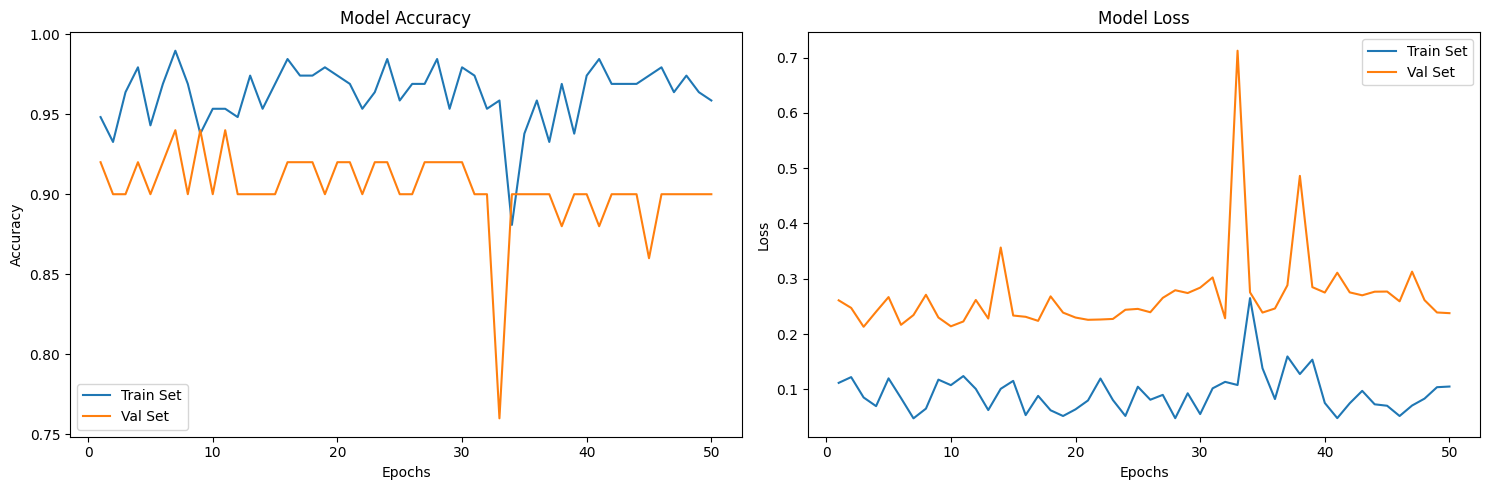

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 139ms/step
Test accuracy: 0.9


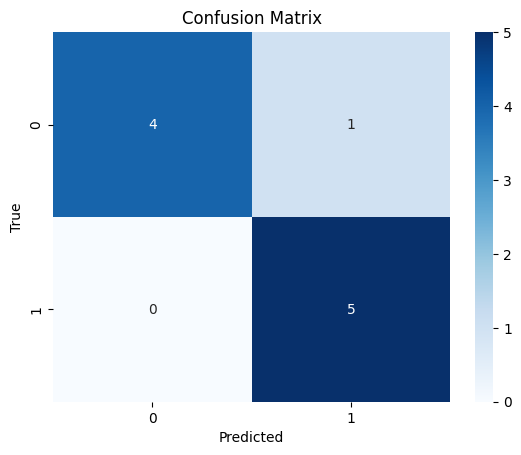

In [58]:
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)

test_accuracy = accuracy_score(Y_test, Y_pred)
print('Test accuracy:', test_accuracy)

cm = confusion_matrix(Y_test, Y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()